# SALES PREDICTION USING ARIMA AND PROPHET FOR BRAZILIAN E-COMMERCE

The dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

**What is ARIMA model?**

A. ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). It has 3 hyperparameters - P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

# 📤 IMPORT LIBRARIES

In [1]:
!pip install statsmodels
!pip install pmdarima

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from scipy import stats
import os
import itertools

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import seaborn as sns
import statsmodels.api as sm

from pylab import rcParams

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings('ignore')


# 💾 CHECK OUT THE DATA

In [3]:
df_item = pd.read_csv("dataset/olist_order_items_dataset.csv")
df_reviews = pd.read_csv("dataset/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("dataset/olist_orders_dataset.csv")
df_products = pd.read_csv("dataset/olist_products_dataset.csv")
df_geolocation = pd.read_csv("dataset/olist_geolocation_dataset.csv")
df_sellers = pd.read_csv("dataset/olist_sellers_dataset.csv")
df_order_pay = pd.read_csv("dataset/olist_order_payments_dataset.csv")
df_customers = pd.read_csv("dataset/olist_customers_dataset.csv")
df_category = pd.read_csv("dataset/product_category_name_translation.csv")

**MERGE DF_ORDERS WITH DF_CUSTOMERS**

In [4]:
df_orders = df_orders.merge(df_customers, on='customer_id', how='outer')

**ALL IN ONE**

In [5]:
# merge all the tables in one dataframe
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
#df_train = df_train.merge(df_customers, on='customer_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

**CONVERT DATE COLUMNS TO TIMESTAMP**

In [6]:
df_train['order_purchase_time'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.time

In [7]:
# Extracting attributes for purchase date - Date
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.date
df_train['order_delivered_customer_date'] = pd.to_datetime(df_train['order_delivered_customer_date']).dt.date
df_train['order_estimated_delivery_date'] = pd.to_datetime(df_train['order_estimated_delivery_date']).dt.date
df_train['order_approved_at'] = pd.to_datetime(df_train['order_approved_at']).dt.date
df_train['order_delivered_carrier_date'] = pd.to_datetime(df_train['order_delivered_carrier_date']).dt.date

In [8]:
# Extracting attributes for purchase date - Year and Month
df_train['order_purchase_year'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.year
df_train['order_purchase_month'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.month
df_train['order_purchase_month_name'] = df_train['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))

In [9]:
# Extracting attributes for purchase date - Day and Day of Week
df_train['order_purchase_day'] = pd.to_datetime(df_train['order_purchase_timestamp']).apply(lambda x: x.day)
df_train['order_purchase_dayofweek'] = pd.to_datetime(df_train['order_purchase_timestamp']).apply(lambda x: x.dayofweek)
df_train['order_purchase_dayofweek_name'] = pd.to_datetime(df_train['order_purchase_timestamp']).dt.day_name()

In [10]:
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp'])
df_train['order_purchase_time'] = pd.to_datetime(df_train['order_purchase_time'],format='%H:%M:%S').dt.time
df_train['order_delivered_customer_date'] = pd.to_datetime(df_train['order_delivered_customer_date'])
df_train['order_estimated_delivery_date'] = pd.to_datetime(df_train['order_estimated_delivery_date'])


In [11]:
df_train.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,order_purchase_time,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:00,2017,10,Oct,2,0,Monday
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1.0,credit_card,3.0,37.77,b46f1e34512b0f4c74a72398b03ca788,4.0,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,18:29:00,2017,8,Aug,15,1,Tuesday
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04,2017-08-07,2017-08-15,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1.0,credit_card,1.0,37.77,dc90f19c2806f1abba9e72ad3c350073,5.0,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,18:24:00,2017,8,Aug,2,2,Wednesday


In [12]:
df_train_state=df_train

In [13]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
 8   customer_unique_id             99441 non-null  object
 9   customer_zip_code_prefix       99441 non-null  int64 
 10  customer_city                  99441 non-null  object
 11  customer_state                 99441 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.9+ MB


# CLEAN DATA

In [15]:
df_orders.shape

(99441, 12)

In [16]:
df_train.isnull().sum().sort_values(ascending = False)

review_comment_title             105154
review_comment_message            68898
order_delivered_customer_date      3421
product_photos_qty                 2542
product_description_lenght         2542
product_name_lenght                2542
product_category_name              2542
order_delivered_carrier_date       2086
review_score                        997
review_id                           997
review_answer_timestamp             997
review_creation_date                997
product_height_cm                   853
product_length_cm                   853
product_weight_g                    853
product_width_cm                    853
price                               833
seller_city                         833
seller_state                        833
freight_value                       833
product_id                          833
seller_id                           833
order_item_id                       833
shipping_limit_date                 833
seller_zip_code_prefix              833


In [17]:
# We may drop the review_comment_title column, as all values are null
df_train.drop(['review_comment_title'], axis=1, inplace=True)

Default review comment message

In [18]:
df_train['review_comment_message'] = df_train['review_comment_message'].fillna('No message')

In [19]:
df_train.isnull().sum().sort_values(ascending = False)

order_delivered_customer_date    3421
product_photos_qty               2542
product_description_lenght       2542
product_name_lenght              2542
product_category_name            2542
order_delivered_carrier_date     2086
review_id                         997
review_answer_timestamp           997
review_creation_date              997
review_score                      997
product_width_cm                  853
product_length_cm                 853
product_weight_g                  853
product_height_cm                 853
seller_id                         833
seller_city                       833
seller_state                      833
shipping_limit_date               833
order_item_id                     833
seller_zip_code_prefix            833
product_id                        833
price                             833
freight_value                     833
order_approved_at                 177
payment_installments                3
payment_value                       3
payment_type

Drop nan values

In [20]:
df_train_0 = df_train.shape[0]
#Remove missing values with dropna
df_train= df_train.dropna()
df_train_1 = df_train.shape[0]
print(f'{round(((df_train_0-df_train_1)/df_train_1)*100,2)}% nan values points were eliminated')

5.24% nan values points were eliminated


In [21]:
df_orders_0 = df_orders.shape[0]
#Remove missing values with dropna
df_orders= df_orders.dropna()
df_orders_1 = df_orders.shape[0]
print(f'{round(((df_orders_0-df_orders_1)/df_orders_1)*100,2)}% nan values points were eliminated')

3.09% nan values points were eliminated


Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?

In [22]:
df_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017 0:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,7/24/2018 20:41,7/26/2018 3:24,7/26/2018 14:31,8/7/2018 15:27,8/13/2018 0:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,8/8/2018 8:38,8/8/2018 8:55,8/8/2018 13:50,8/17/2018 18:06,9/4/2018 0:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,11/18/2017 19:28,11/18/2017 19:45,11/22/2017 13:39,12/2/2017 0:28,12/15/2017 0:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2/13/2018 21:18,2/13/2018 22:20,2/14/2018 19:46,2/16/2018 18:17,2/26/2018 0:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,3/9/2017 9:54,3/9/2017 9:54,3/10/2017 11:18,3/17/2017 15:08,3/28/2017 0:00,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2/6/2018 12:58,2/6/2018 13:10,2/7/2018 23:22,2/28/2018 17:37,3/2/2018 0:00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,8/27/2017 14:46,8/27/2017 15:04,8/28/2017 20:52,9/21/2017 11:24,9/27/2017 0:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,1/8/2018 21:28,1/8/2018 21:36,1/12/2018 15:35,1/25/2018 23:32,2/15/2018 0:00,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [23]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,10/10/2017 21:25,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,2018-07-26 03:24:00,2018-07-26 14:31:00,8/7/2018 15:27,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,2018-08-08 08:55:00,2018-08-08 13:50:00,8/17/2018 18:06,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:00,2017-11-18 19:45:00,2017-11-22 13:39:00,12/2/2017 0:28,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:00,2018-02-13 22:20:00,2018-02-14 19:46:00,2/16/2018 18:17,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


NameError: name 'single_countplot' is not defined

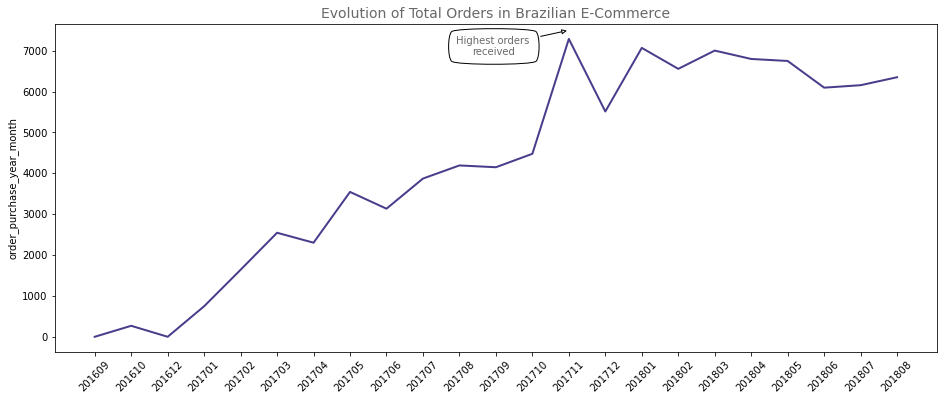

In [35]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
#ax2 = fig.add_subplot(gs[1, 0])
#ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

#format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()



# VISUALIZATION

# Price Distribution

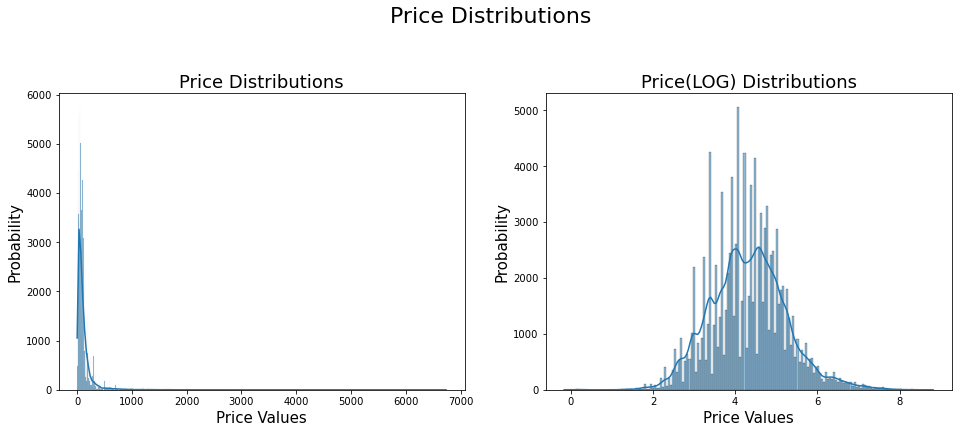

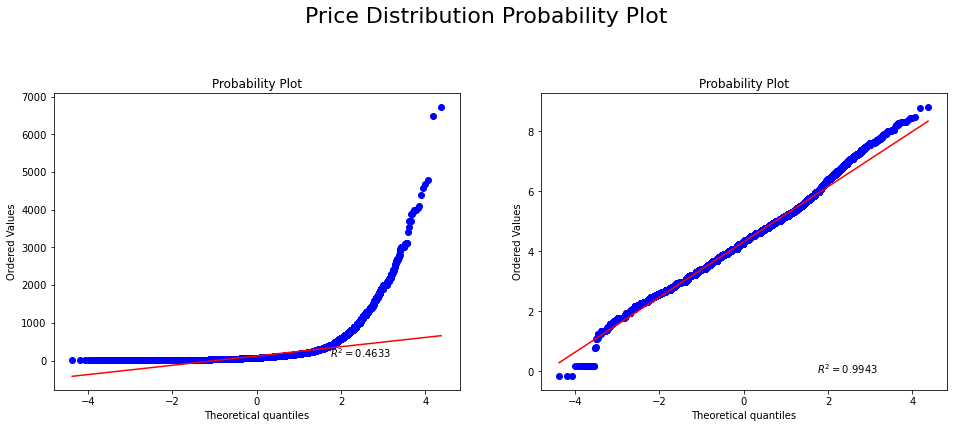

In [24]:
# Getting the histogram and normal probability plot
plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions', fontsize=22)
plt.subplot(221)
g = sns.histplot(df_train['price'], kde=True)
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values", fontsize=15)
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df_train['price']), kde=True)
g1.set_title("Price(LOG) Distributions", fontsize=18)
g1.set_xlabel("Price Values", fontsize=15)
g1.set_ylabel("Probability", fontsize=15)

plt.show()

plt.figure(figsize=(16,12))

plt.suptitle('Price Distribution Probability Plot', fontsize=22)

plt.subplot(221)
res = stats.probplot(df_train['price'], plot=plt, fit=True, rvalue=True);


plt.subplot(222)
res = stats.probplot(np.log(df_train['price']), plot=plt, fit=True, rvalue=True);

plt.show()

**Price Distribution:**
Histogram of a sample from a right-skewed distribution – it looks unimodal and skewed right.

**Price Log Distribution:**
Histogram of a sample from a normal distribution – it looks fairly symmetric and unimodal.

**Probability Plot - Price Distribution:**
Normal probability plot of a sample from a right-skewed distribution – it has an inverted C shape.

**Probability Plot - Price Log Distribution:**
Normal probability plot of a sample from a normal distribution – it looks fairly straight, at least when the few large and small values are ignored.

Let's Check the Features Through the Time

Our current timestamps can be tricky to work with, so we'll be using the average daily price amount for that month, and we're using the start of each month as the timestamp.

In [25]:
df_train['order_purchase_timestamp'].min(), df_train['order_purchase_timestamp'].max()

(Timestamp('2016-10-03 00:00:00'), Timestamp('2018-08-29 00:00:00'))

In [26]:
df_orders['order_purchase_year_month'].min(), df_orders['order_purchase_year_month'].max()

('201609', '201808')

In [27]:
df_train = df_train.groupby('order_purchase_timestamp')['price'].sum().reset_index()
df_train

,order_purchase_timestamp,price
0,2016-10-03,463.48
1,2016-10-04,9093.20
2,2016-10-05,6329.57
3,2016-10-06,5889.96
4,2016-10-07,6205.25
...,...,...
606,2018-08-25,10711.93
607,2018-08-26,8235.71
608,2018-08-27,5343.67
609,2018-08-28,3757.51


In [ ]:
df_orders = df_orders.groupby('order_purchase_year_month')['price'].sum().reset_index()
df_orders

**Indexing with Time Series of Data**

In [28]:
df_train=df_train.set_index('order_purchase_timestamp')
df_train.index

DatetimeIndex(['2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06',
               '2016-10-07', '2016-10-08', '2016-10-09', '2016-10-10',
               '2016-12-23', '2017-01-05',
               ...
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29'],
              dtype='datetime64[ns]', name='order_purchase_timestamp', length=611, freq=None)

In [29]:
sales = df_train['price'].resample('MS').sum()
sales

order_purchase_timestamp
2016-10-01      41659.92
2016-11-01          0.00
2016-12-01         10.90
2017-01-01     116505.92
2017-02-01     234576.40
2017-03-01     370039.64
2017-04-01     349985.58
2017-05-01     516221.98
2017-06-01     437903.81
2017-07-01     510081.68
2017-08-01     572738.71
2017-09-01     635652.10
2017-10-01     655969.70
2017-11-01    1008005.90
2017-12-01     728074.99
2018-01-01     934616.32
2018-02-01     850476.08
2018-03-01     971126.98
2018-04-01     994816.77
2018-05-01    1003273.80
2018-06-01     895916.69
2018-07-01     882403.12
2018-08-01     861115.49
Freq: MS, Name: price, dtype: float64

# **Viewing Furniture Sales Time Series Data**

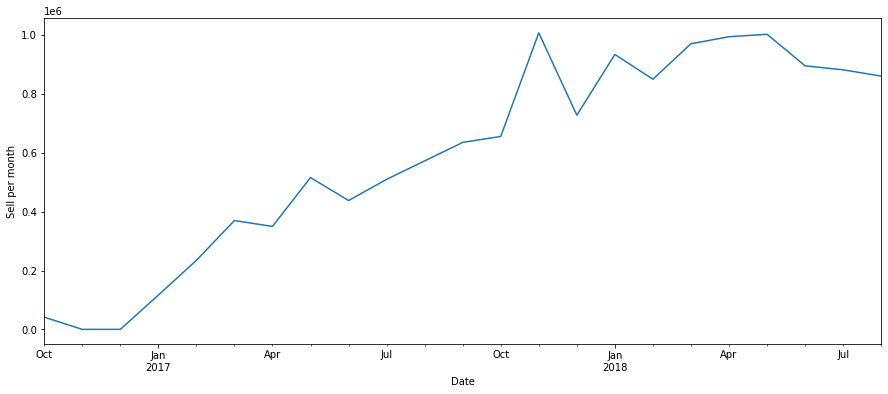

In [30]:
sales.plot(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Sell per month')
plt.show()

In [31]:
#Determine rolling statistics
sales_mean = sales.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
sales_std = sales.rolling(window=12).std()
print(sales_mean,sales_std)

order_purchase_timestamp
2016-10-01              NaN
2016-11-01              NaN
2016-12-01              NaN
2017-01-01              NaN
2017-02-01              NaN
2017-03-01              NaN
2017-04-01              NaN
2017-05-01              NaN
2017-06-01              NaN
2017-07-01              NaN
2017-08-01              NaN
2017-09-01    315448.053333
2017-10-01    366640.535000
2017-11-01    450641.026667
2017-12-01    511313.034167
2018-01-01    579488.900833
2018-02-01    630813.874167
2018-03-01    680904.485833
2018-04-01    734640.418333
2018-05-01    775228.070000
2018-06-01    813395.810000
2018-07-01    844422.596667
2018-08-01    868453.995000
Freq: MS, Name: price, dtype: float64 order_purchase_timestamp
2016-10-01              NaN
2016-11-01              NaN
2016-12-01              NaN
2017-01-01              NaN
2017-02-01              NaN
2017-03-01              NaN
2017-04-01              NaN
2017-05-01              NaN
2017-06-01              NaN
2017-07-01      

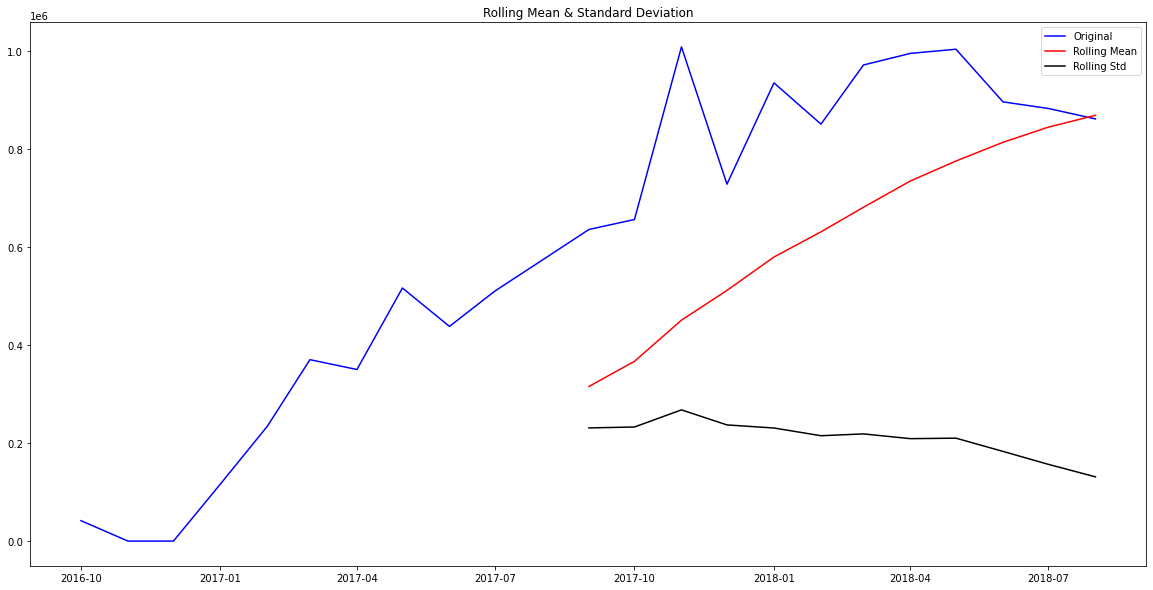

In [32]:
#Plot rolling statistics
plt.figure(figsize=(20,10))
orig = plt.plot(sales, color='blue', label='Original')
sales_mean = plt.plot(sales_mean, color='red', label='Rolling Mean')
sales_std = plt.plot(sales_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [33]:
# Primeiro, vamos decompor a série pra avaliar tendência
# Sazonalidade e resíduo
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df_train)

fig = plt.figure(figsize=(8, 6))  
fig = resultado.plot()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

Teste de estacionariedade

In [50]:
# Teste de estacionariedade. 
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(df_orders['order_purchase_year_month'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-309.2888963056311
p-valor:0.0


**Como p-valor <0.05, rejeita-se a hipótese nula de que a série não é estacionária.**

# ARIMA Model for Time Series Forecasting

Let's apply one of the most used methods for forecasting time series, known as ARIMA, which stands Autoregressive Integrated Moving Average.

ARIMA models are denoted with the ARIMA notation (p, d, q). These three parameters are responsible for the seasonality, trend and noise in the data:

In [45]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [46]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue           


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:685.0019235924298
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:683.0602837480974
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:331.0101504543771
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:326.9690608435736
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:683.2077906491562
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:684.7289753778051
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:365.1096245242882
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:325.92208267527536
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:676.1709553919047
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:677.8383616186684
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:322.53652172659724
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:323.88253284218354
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:677.8257599480814
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:679.8257599981199
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:321.15352027677733
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:323.1516873003424
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:582.7363857732793
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:584.6772989984893
ARIMA(

A saída acima sugere que o SARIMAX (0, 1, 0) x (1, 1, 0, 12) produz o menor valor de AIC de 4.0. Portanto, devemos considerar isso como a melhor opção.

# Adjusting the ARIMA model

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   23
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -287.373
Date:                Thu, 06 Jan 2022   AIC                            580.746
Time:                        01:45:29   BIC                            584.019
Sample:                    10-01-2016   HQIC                           581.517
                         - 08-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8042      0.395     -2.034      0.042      -1.579      -0.029
ma.L1          0.4745      0.480      0.989      0.323      -0.466       1.415
sigma2      1.453e+10   4.76e-11   3.05e+20      0.0

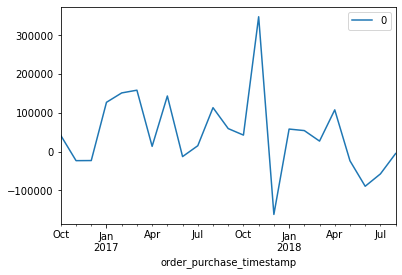

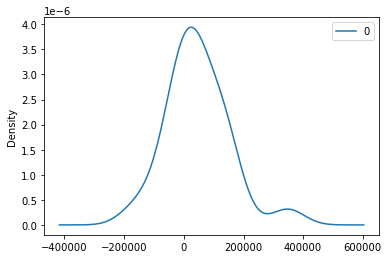

                   0
count      23.000000
mean    46372.979097
std    103374.208452
min   -161980.068283
25%    -17889.324043
50%     41659.920000
75%    110640.675821
max    348116.878794


In [39]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
# fit model
model = ARIMA(sales, order=(1,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [53]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX (versão do arima com parametros para sazonalidade)

mod = sm.tsa.statespace.SARIMAX(sales,
                                order=(1, 1, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit(disp=False)
print(results.summary().tables[1])
results.summary()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4790      0.225     -2.129      0.033      -0.920      -0.038
sigma2       1.16e+10   4.73e-12   2.45e+21      0.000    1.16e+10    1.16e+10


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                   23
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -135.908
Date:                            Thu, 06 Jan 2022   AIC                            275.816
Time:                                    01:59:04   BIC                            276.421
Sample:                                10-01-2016   HQIC                           275.152
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4790      0.225     -2.129      0.033      -0.920      -0.038
sigma2       1.16e+10   4.73e-12   2.45e+21      0.000    1.16e+10    1.16e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                12.52
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                             2.16
Prob(H) (two-sided):                  0.26   Kurtosis:                         6.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+37. Standard errors may be unstable.
"""

In [55]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = results.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [56]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(331622.41844030406, 753841.3197961668)

In [57]:
predicao_media[0]

542731.8691182354

In [59]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(sales.index)

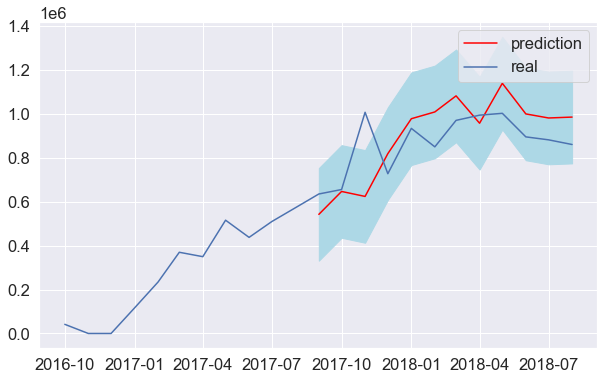

In [62]:
plt.figure(figsize=(10,6))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='lightblue')
plt.plot(datas, sales, label='real')
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(sales[-12:].values,predicao_media.values))
print(rmse_sarima)

147303.2082481845


**Customer's State Distribution**

In [40]:
df_train_state

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,order_purchase_time,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:33,2017,10,Oct,2,0,Monday
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:33,2017,10,Oct,2,0,Monday
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,10:56:33,2017,10,Oct,2,0,Monday
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1.0,credit_card,3.0,37.77,b46f1e34512b0f4c74a72398b03ca788,4.0,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,18:29:31,2017,8,Aug,15,1,Tuesday
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04,2017-08-07,2017-08-15,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1.0,credit_card,1.0,37.77,dc90f19c2806f1abba9e72ad3c350073,5.0,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,18:24:47,2017,8,Aug,2,2,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,1ab38815794efa43d269d62b98dae815,a0b67404d84a70ef420a7f99ad6b190a,delivered,2018-07-01,2018-07-05,2018-07-04,2018-07-09,2018-07-20,2077f7ec37df79c62cc24b7b8f30e8c9,8528,ferraz de vasconcelos,SP,1.0,31ec3a565e06de4bdf9d2a511b822b4d,babcc0ab201e4c60188427cae5

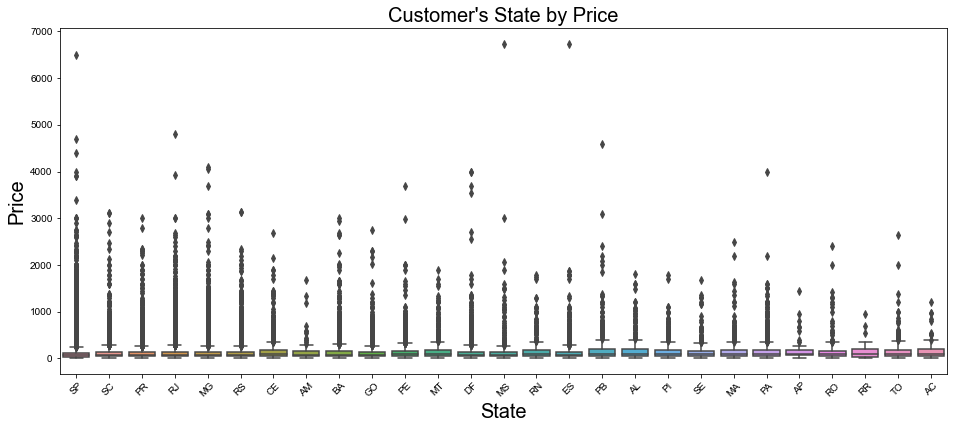

In [41]:
plt.figure(figsize=(35,14))

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price', 
                 data=df_train_state[df_train_state['price'] != -1])
g2.set_title("Customer's State by Price", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

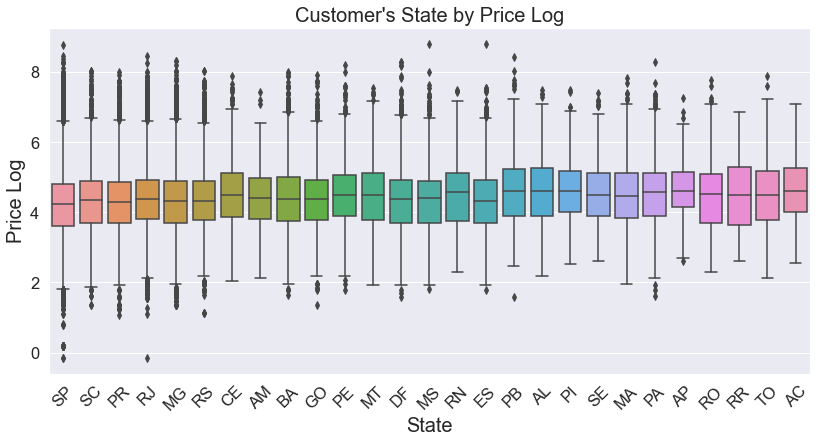

In [42]:
plt.figure(figsize=(30,14))
df_train_state['price_log'] = np.log(df_train_state['price'])

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price_log', 
                 data=df_train_state[df_train_state['price'] != -1])
g2.set_title("Customer's State by Price Log", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price Log", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

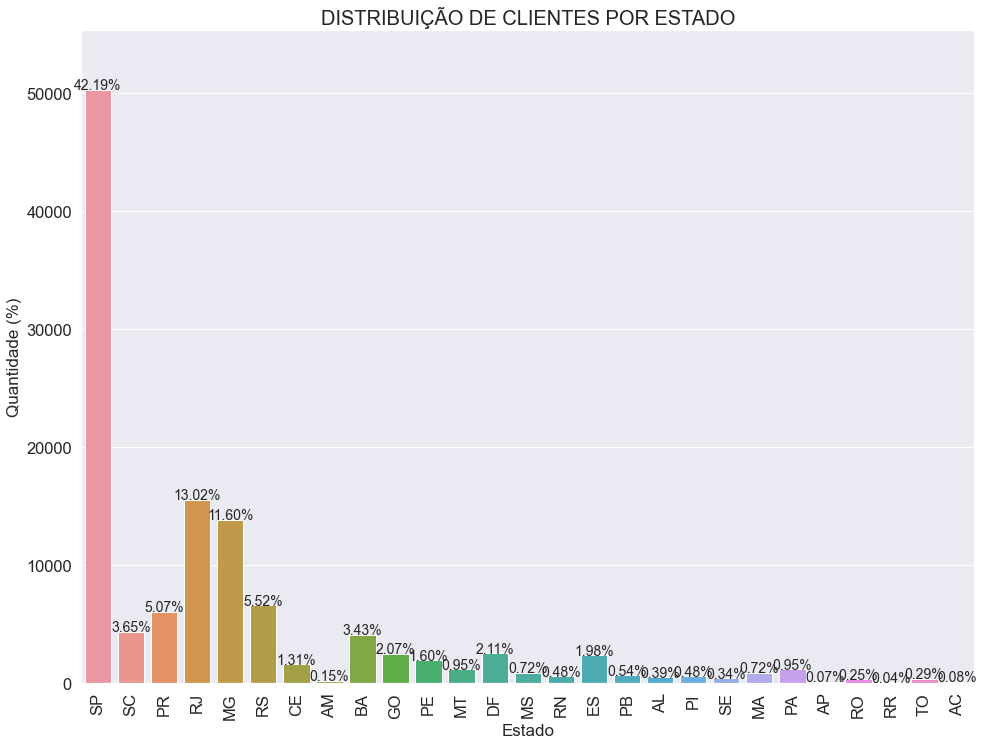

In [44]:
plt.figure(figsize=(16,12))

g = sns.countplot(x='customer_state', data=df_train_state, orient='h')
g.set_title("DISTRIBUIÇÃO DE CLIENTES POR ESTADO", fontsize=20)
g.set_xlabel("Estado", fontsize=17)
g.set_ylabel("Quantidade (%)", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
sizes = []
total=len(df_train_state)

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.1)

plt.show()


https://github.com/letsdata/series-temporais-python/blob/main/series-temporais-python.ipynb